# This notebook contains the empirical study regarding the attention mechanism.

______________
# FINAL STEPS:
* Train networks on MNIST for X epochs
* Train networks for augmented MNIST for X epochs
* Ablation Study (VAN without LKA)
* Compare Computational Costs (Deepspeed Profiler?)
 - Training time
 - Number of Modules
 - Number of parameters
 - FLOPs
 

# Relevant information about the training run

- OS: Linux-5.15.133+-x86_64-with-glibc2.31
- GPU: Tesla P100-PCIE-16GB
- PyTorch: 2.1.2
- CUDA: 12.1
- cudnn: 8900
- Python Version: 3.10.13

# Relevant information about the external package versions
- matplotlib==3.7.5
- numpy @ file:///home/conda/feedstock_root/build_artifacts/numpy_1707225380409/work/dist/numpy-1.26.4-cp310-cp310-linux_x86_64.whl#sha256=51131fd8fc130cd168aecaf1bc0ea85f92e8ffebf211772ceb16ac2e7f10d7ca
- torch @ file:///tmp/torch/torch-2.1.2-cp310-cp310-linux_x86_64.whl#sha256=ae3259980b8d6551608b32fde2695baca64c72ed15ab2332023a248c113815a8
- torchvision @ file:///tmp/torch/torchvision-0.16.2-cp310-cp310-linux_x86_64.whl#sha256=105901a20924f652ee62df0bb57580c67725eb21f11a349658952c4be2050d94


In [2]:
# Installation and import of relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pickle
import platform
import random
import time
import torch
from torchvision import datasets, transforms
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.profiler import profile, record_function, ProfilerActivity

In [2]:
# Get information about current runtime and package versions.

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Get CUDA device count
cuda_device_count = torch.cuda.device_count() if cuda_available else 0

# Get current CUDA device index
cuda_device_index = torch.cuda.current_device() if cuda_available else None

# Get name of current CUDA device
cuda_device_name = torch.cuda.get_device_name(cuda_device_index) if cuda_available else None

# Get CUDA capability of the device
cuda_capability = torch.cuda.get_device_capability(cuda_device_index) if cuda_available else None

# Get CUDA version
cuda_version = torch.version.cuda if cuda_available else None

# Get cuDNN version
cudnn_version = torch.backends.cudnn.version() if cuda_available else None

# Get PyTorch version
pytorch_version = torch.__version__

# Get OS information
os_info = platform.platform()

python_version = platform.python_version()

# Print the information
environment_dict = {"OS:", os_info,
                    "GPU:", cuda_device_name,
                    "PyTorch:", pytorch_version,
                    "CUDA:", cuda_version,
                    "cudnn:", cudnn_version,
                    "Python Version:", python_version
                   }
print("OS:", os_info)
print("GPU:", cuda_device_name)
print("PyTorch:", pytorch_version)
print("CUDA:", cuda_version)
print("cudnn:", cudnn_version)
print("Python Version:", python_version)

OS: Linux-5.15.133+-x86_64-with-glibc2.31
GPU: Tesla P100-PCIE-16GB
PyTorch: 2.1.2
CUDA: 12.1
cudnn: 8900
Python Version: 3.10.13


In [3]:
# List package versions
!pip freeze

absl-py==1.4.0
accelerate==0.27.2
access==1.1.9
affine==2.4.0
aiobotocore==2.11.2
aiofiles==22.1.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1701099469104/work
aiohttp-cors==0.7.0
aioitertools==0.11.0
aiorwlock==1.3.0
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1667935791922/work
aiosqlite==0.19.0
albumentations==1.4.0
alembic==1.13.1
altair==5.2.0
annotated-types @ file:///home/conda/feedstock_root/build_artifacts/annotated-types_1696634205638/work
annoy==1.17.3
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1702909220329/work
apache-beam==2.46.0
aplus==0.11.0
appdirs==1.4.4
archspec @ file:///home/conda/feedstock_root/build_artifacts/archspec_1699370045702/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1695386546427/work
array-record==0.5.0
arrow @ file:///home/conda/fe

In [ ]:
######################################
### CREATE CLUTTERED MNIST DATASET ###
######################################

In [3]:
# Create Transformation classes

class RandomPlacement(object):
  def __call__(self, img):
    canvas = torch.zeros(1,100,100)
    x = torch.randint(0, 73, (1,))
    y = torch.randint(0, 73, (1,))
    canvas[:, x:x+28, y:y+28] = img

    return canvas

class RandomCropAndCombine(object):
  def __init__(self, dataset):
    self.dataset = dataset

  def __call__(self, canvas):
    for _ in range(8):
      img, _ = random.choice(self.dataset)
      img = transforms.ToTensor()(img)
      x = torch.randint(0, 91, (1,))
      y = torch.randint(0, 91, (1,))
      patch = transforms.RandomCrop((9,9))(img)
      canvas[:, x:x+9, y:y+9] += patch
      canvas = canvas.clamp(0, 1)

    return canvas

In [4]:
# Create cluttered MNIST dataset, split datasets and create DataLoaders.

# Set seed for reproducability
torch.manual_seed(1)
np.random.seed(1)
generator = torch.Generator().manual_seed(1)

# Set batch size parameter
BATCH_SIZE = 128

# Define data transformations
original_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_original = datasets.MNIST(root='/content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/', train=True, download=True, transform=None)
augmented_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    RandomPlacement(),
    RandomCropAndCombine(mnist_original),
])

# Train datasets
mnist_dataset_train = datasets.MNIST(root='/content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/', train=True, download=True, transform=original_transform)
augmented_dataset_train = datasets.MNIST(root='/content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/', train=True, download=True, transform=augmented_transform)

# Test datasets
augmented_dataset_test = datasets.MNIST(root='/content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/', train=False, download=True, transform=augmented_transform)
mnist_dataset_test = datasets.MNIST(root='/content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/', train=False, download=True, transform=original_transform)

# Split train dataset into 90% train and 10% validation data
mnist_train, mnist_val = torch.utils.data.random_split(dataset=mnist_dataset_train, lengths=[0.9, 0.1], generator=generator)
augmented_train, augmented_val = torch.utils.data.random_split(dataset=augmented_dataset_train, lengths=[0.9, 0.1], generator=generator)

# Create data loaders for original and augmented datasets

# Load train data
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, shuffle=True)
train_loader = torch.utils.data.DataLoader(dataset=augmented_train, batch_size=BATCH_SIZE, shuffle=True)
# Load validation data
mnist_val_loader = torch.utils.data.DataLoader(dataset=mnist_val, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=augmented_val, batch_size=BATCH_SIZE, shuffle=True)
# Load test data
test_loader = torch.utils.data.DataLoader(dataset=augmented_dataset_test, batch_size=BATCH_SIZE, shuffle=False)
mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15807816.45it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 460478.19it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3780214.67it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2048664.24it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw



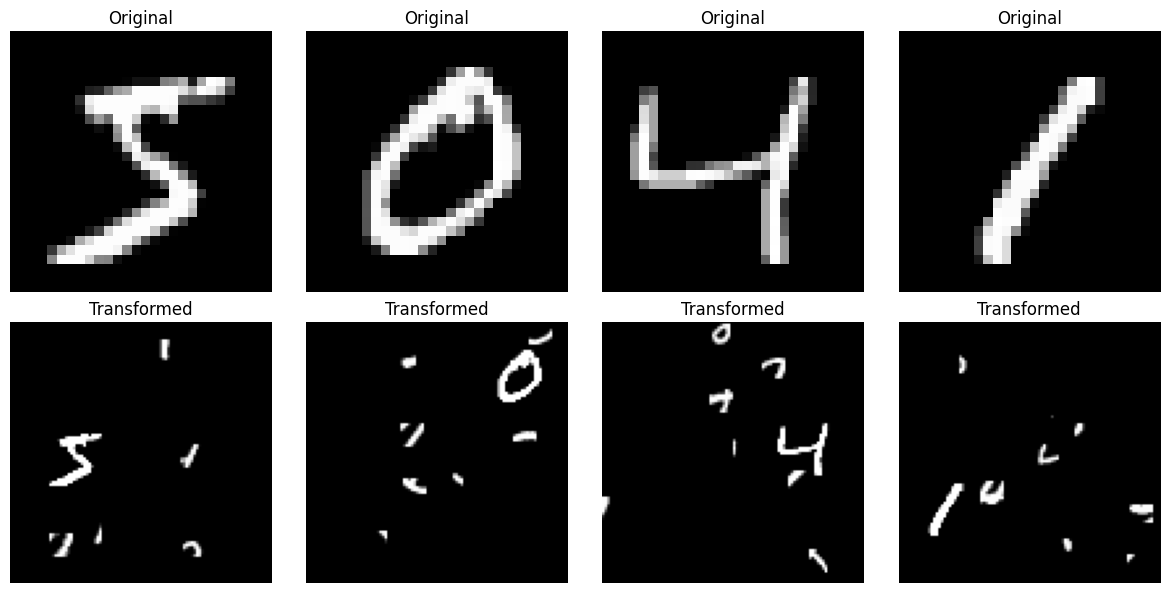

In [5]:
# Plot the original and the augmented dataset
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
  original_img, _ = mnist_original[i]
  original_img = transforms.ToTensor()(original_img).squeeze(0)
  axes[0, i].imshow(original_img, cmap='gray')
  axes[0, i].axis('off')
  axes[0, i].set_title('Original')

  augmented_img, _ = augmented_dataset_train[i]
  augmented_img = augmented_img.squeeze(0)
  axes[1, i].imshow(augmented_img, cmap='gray')
  axes[1, i].axis('off')
  axes[1, i].set_title('Transformed')
    
plt.tight_layout()
plt.show()

In [ ]:
###############################################################
### Helper Trainer Class to faciliate training the networks ###
###############################################################

In [10]:
class Trainer():
    '''
    Trainer class containing multiple helper functions for training.
    '''
    def __init__(self, model, optimizer, train_loader, val_loader, test_loader,
                 num_epochs, estimate_step=100, save_checkpoints=True, path='model'):
        
        self.model = model
        self.optimizer = optimizer
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
        self.criterion = nn.CrossEntropyLoss()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.estimate_step = estimate_step
        self.model_name = type(self.model).__name__
        self.path = path
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.save_checkpoints = save_checkpoints
        self.running_loss_train = []
        self.running_loss_val = []
        self.train_time_per_epoch = []
        self.total_epochs_trained = 0
        self.test_accuracy = None
        self.inference_time = None

    
    def train(self):
        '''
        Function to train the model. Trains the model on a training dataset and evaluates the current performance
        on a validation dataset at the end of each epoch. Reduces the learning rate, if there is no
        improvement in the validation loss for 10 epochs. 
        '''
        self.model.to(self.device)
        self.model.train()
        for epoch in range(self.num_epochs):
            # Start timer
            #torch.cuda.synchronize() if self.device == 'cuda' else None
            start_epoch = time.time()
            
            # Training process for one epoch
            self.model.train(True)
            running_loss_train = 0.00
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad(set_to_none=True)
                output = self.model(data)
                loss = self.criterion(output, target)
                running_loss_train += loss.item()
                loss.backward()
                self.optimizer.step()
                if batch_idx % self.estimate_step == 0:
                    print(f'Epoch {epoch+1}/{self.num_epochs}, Batch {batch_idx}/{len(self.train_loader)}, Train Loss: {loss.item():.4f}')     
            avg_loss_train = running_loss_train / len(self.train_loader)
            self.running_loss_train.append(avg_loss_train)
            
            # Validate model at the end of each epoch
            self.model.eval()
            running_loss_val = 0.00
            with torch.no_grad():
                for i, (data_val, target_val) in enumerate(self.val_loader):
                    data_val, target_val = data_val.to(self.device), target_val.to(self.device)
                    output_val = self.model(data_val)
                    loss_val = self.criterion(output_val, target_val)
                    running_loss_val += loss_val.item()
                avg_loss_val = running_loss_val / len(self.val_loader)
                self.running_loss_val.append(avg_loss_val)
            
            # Recuce LR if model does not improve for 10 epochs
            self.scheduler.step(avg_loss_val)
            
            # Track training time for each epoch
            #torch.cuda.synchronize() if self.device == 'cuda' else None
            end_epoch = time.time()
            self.train_time_per_epoch.append(end_epoch-start_epoch)
            print(f'Model {self.model_name} at epoch {epoch+1}/{self.num_epochs}: Avg Train Loss: {avg_loss_train:.4f}, Avg Val Loss: {avg_loss_val:.4f}')
            
            # Increase epoch counter
            self.total_epochs_trained += 1
            
            # Save checkpoint at the end of each epoch
            if self.save_checkpoints:
                self.save_checkpoint(self.path)
            
        # Print total training time at the end
        train_time = "{:.2f} minutes".format(sum(self.train_time_per_epoch) / 60)
        print(f'Model {self.model_name} took {train_time} to run on {self.total_epochs_trained} epochs.')
        
                
    def eval(self):
        '''
        Function to evaluate the performance of the model.
        Therefore, the models accuracy on a test dataset is measured.
        '''
        self.model.to(self.device)
        self.model.eval()
        correct = 0
        total = 0
        
        #torch.cuda.synchronize() if self.device == 'cuda' else None
        start_eval = time.time()
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        self.test_accuracy = correct / total
        
        #torch.cuda.synchronize() if self.device == 'cuda' else None
        end_eval = time.time()
        self.inference_time = end_eval - start_eval
        print(f'Test Accuracy for {self.model_name}: {self.test_accuracy:.4f} - in {self.inference_time} seconds.')
        # Save checkpoint after inference.
        if self.save_checkpoints:
                self.save_checkpoint(self.path)
    def save_checkpoint(self, path):
        '''
        Function to save the current state of the model, optimizer and scheduler.
        Also saves the model metrics training loss, validation loss, accuracy,
        training and inference time.
        '''
        torch.save({'epoch': self.total_epochs_trained,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'scheduler_state_dict': self.scheduler.state_dict(),
                    'loss': self.running_loss_train[-1],
                    'running_loss_train': self.running_loss_train,
                    'running_loss_val': self.running_loss_val,
                    'test_accuracy': self.test_accuracy,
                    'train_time': self.train_time_per_epoch,
                    'inference_time': self.inference_time}, 
                    f'{path}.pth')

In [11]:
###############################################
### CNN model for MNIST and cluttered MNIST ###
###############################################
# NOTE: Only difference if the models is the linear layer fc1. Input features needs adjustment as the size of the input images is different.

In [115]:
###############################
####### CNN Model MNIST #######
###############################
class CNN_MNIST(nn.Module):
    def __init__(self, num_classes=10, image_channels=1):
        super(CNN_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(image_channels, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(9216, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [116]:
#################################
####### CNN Model Clutter #######
#################################
class CNN(nn.Module):
    def __init__(self, num_classes=10, image_channels=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(image_channels, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(147456, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [14]:
###############################################
### VAN model for MNIST and cluttered MNIST ###
###############################################

In [124]:
###############################
####### VAN Model MNIST #######
###############################
class Downsampling_MNIST(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride):
    super().__init__()

    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)

  def forward(self, x):

    x = self.conv(x)

    return x


class Block_MNIST(nn.Module):
  def __init__(self, channels, expansion_ratio, dropout):
    super().__init__()

    self.batch_norm1 = nn.BatchNorm2d(channels) 
    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels ,kernel_size=1)
    self.act1 = nn.GELU()
    self.LKA = LKA_MNIST(in_channels=channels, out_channels=channels)
    self.batch_norm2 = nn.BatchNorm2d(channels)
    self.FFN = FFN_MNIST(channels=channels, expansion_ratio=expansion_ratio, dropout=dropout)

  def forward(self, x):
    x = self.batch_norm1(x)
    x = self.conv1(x)
    x = self.act1(x)
    x = self.LKA(x)
    x = self.batch_norm2(x)
    x = self.FFN(x)

    return x


class FFN_MNIST(nn.Module):
  def __init__(self, channels, expansion_ratio, dropout):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels*expansion_ratio, kernel_size=1)
    self.conv2 = nn.Conv2d(in_channels=channels*expansion_ratio, out_channels=channels*expansion_ratio,
                           kernel_size=3, stride=1, padding=1, groups=channels*expansion_ratio)  #DW3x3Conv
    self.act1 = nn.GELU()
    self.conv3 = nn.Conv2d(in_channels=channels*expansion_ratio, out_channels=channels, kernel_size=1)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.act1(x)
    x = self.conv3(x)
    x = self.dropout(x)

    return x


class LKA_MNIST(nn.Module):
  def __init__(self, in_channels, out_channels, k=1):
    super().__init__()
    '''
    When groups == in_channels and out_channels == K * in_channels,
    where K is a positive integer, this operation is also known as a “depthwise convolution”.
    '''
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels*k, kernel_size=5, groups=in_channels)#DW-Conv
    self.conv2 = nn.Conv2d(in_channels=in_channels*k, out_channels=in_channels*k, kernel_size=5,
                           dilation=3, groups=in_channels, padding=8)#DW-D-Conv
    self.conv3 = nn.Conv2d(in_channels=in_channels*k, out_channels=out_channels, kernel_size=1) #1x1 Conv

  def forward(self, x):
    input = x.clone()
    attn = self.conv1(x)
    attn = self.conv2(attn)
    attn = self.conv3(attn)

    return input * attn


class VAN_MNIST(nn.Module):
  def __init__(self, num_classes=10, stages=4, l=[2, 2, 1, 1], channels=[32, 64, 128, 256],
               expansion_ratio=[2, 2, 2, 2], image_channels=1, dropout=0.5):
    super().__init__()
    '''
    The block and downsampler need to be initialized within the __init__ method in order to
    determine the number of parameters correctly. This also makes the moving to device easier,
    as moving the whole model will move the blocks and downsamplers aswell.
    '''
    self.stages = stages
    self.channels = channels
    self.expansion_ratio = expansion_ratio
    self.l = l
    self.num_classes = num_classes
    self.classifier = nn.Linear(in_features=channels[-1], out_features=num_classes)

    for j in range(self.stages):
      downsampler = Downsampling_MNIST(in_channels=image_channels if j == 0 else self.channels[j-1],
                                 out_channels=self.channels[j],
                                 kernel_size=3, stride=2)
      block = nn.ModuleList([Block_MNIST(channels=self.channels[j],
                                   expansion_ratio=self.expansion_ratio[j],
                                   dropout=dropout)
                                   for _ in range(self.l[j])])

      setattr(self, f'downsampler_{j+1}', downsampler)
      setattr(self, f'block_{j+1}', block)

  def forward(self, x):

    for j in range(self.stages):

      downsampler = getattr(self, f'downsampler_{j+1}')
      block = getattr(self, f'block_{j+1}')
      x = downsampler(x)
      for blk in block:
        x = blk(x)

    x = x.flatten(2).transpose(1, 2)
    x = x.mean(dim=1)
    x = self.classifier(x)

    return x

In [123]:
#################################
####### VAN Model Clutter #######
#################################
class Downsampling(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride):
    super().__init__()

    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)

  def forward(self, x):

    x = self.conv(x)

    return x


class Block(nn.Module):
  def __init__(self, channels, expansion_ratio, dropout):
    super().__init__()

    self.batch_norm1 = nn.BatchNorm2d(channels) 
    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels ,kernel_size=1)
    self.act1 = nn.GELU()
    self.LKA = LKA(in_channels=channels, out_channels=channels)
    self.batch_norm2 = nn.BatchNorm2d(channels)
    self.FFN = FFN(channels=channels, expansion_ratio=expansion_ratio, dropout=dropout)

  def forward(self, x):
    x = self.batch_norm1(x)
    x = self.conv1(x)
    x = self.act1(x)
    x = self.LKA(x)
    x = self.batch_norm2(x)
    x = self.FFN(x)

    return x


class FFN(nn.Module):
  def __init__(self, channels, expansion_ratio, dropout):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels*expansion_ratio, kernel_size=1)
    self.conv2 = nn.Conv2d(in_channels=channels*expansion_ratio, out_channels=channels*expansion_ratio,
                           kernel_size=3, stride=1, padding=1, groups=channels*expansion_ratio)  #DW-3x3 Conv
    self.act1 = nn.GELU()
    self.conv3 = nn.Conv2d(in_channels=channels*expansion_ratio, out_channels=channels, kernel_size=1)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.act1(x)
    x = self.conv3(x)
    x = self.dropout(x)

    return x


class LKA(nn.Module):
  def __init__(self, in_channels, out_channels, k=1):
    super().__init__()
    '''
    When groups == in_channels and out_channels == K * in_channels,
    where K is a positive integer, this operation is also known as a “depthwise convolution”.
    '''
    
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels*k, kernel_size=5, groups=in_channels)#DW-Conv
    self.conv2 = nn.Conv2d(in_channels=in_channels*k, out_channels=in_channels*k, kernel_size=5,
                           dilation=3, groups=in_channels, padding=8)#DW-D-Conv
    self.conv3 = nn.Conv2d(in_channels=in_channels*k, out_channels=out_channels, kernel_size=1) #1x1 Conv

  def forward(self, x):
    input = x.clone()
    attn = self.conv1(x)
    attn = self.conv2(attn)
    attn = self.conv3(attn)

    return input * attn


class VAN(nn.Module):
  def __init__(self, num_classes=10, stages=4, l=[2, 2, 1, 1], channels=[32, 64, 128, 256],
               expansion_ratio=[2, 2, 2, 2], image_channels=1, dropout=0.5):
    super().__init__()
    '''
    The block and downsampler need to be initialized within the __init__ method in order to
    determine the number of parameters correctly. This also makes the moving to device easier,
    as moving the whole model will move the blocks and downsamplers aswell.
    '''
    self.stages = stages
    self.channels = channels
    self.expansion_ratio = expansion_ratio
    self.l = l
    self.num_classes = num_classes
    self.classifier = nn.Linear(in_features=channels[-1], out_features=num_classes)

    for j in range(self.stages):
      downsampler = Downsampling(in_channels=image_channels if j == 0 else self.channels[j-1],
                                 out_channels=self.channels[j],
                                 kernel_size=3, stride=2)
      block = nn.ModuleList([Block(channels=self.channels[j],
                                   expansion_ratio=self.expansion_ratio[j],
                                   dropout=dropout)
                                   for _ in range(self.l[j])])

      setattr(self, f'downsampler_{j+1}', downsampler)
      setattr(self, f'block_{j+1}', block)

  def forward(self, x):

    for j in range(self.stages):

      downsampler = getattr(self, f'downsampler_{j+1}')
      block = getattr(self, f'block_{j+1}')
      x = downsampler(x)
      for blk in block:
        x = blk(x)

    x = x.flatten(2).transpose(1, 2)
    x = x.mean(dim=1)
    x = self.classifier(x)

    return x

# TRAINING PROCESS DONE. DO NOT TOUCH ANY OF THE TRAINING LINES

In [ ]:
################################
### TRAINING OF THE NETWORKS ###
################################

In [137]:
####################
### CNN Training ###
####################

In [136]:
# Initialize CNN on MNIST
cnn_mnist = CNN_MNIST()
cnn_mnist_optimizer = optim.AdamW(cnn_mnist.parameters(), lr=1e-3)
cnn_mnist_trainer = Trainer(model=cnn_mnist, optimizer=cnn_mnist_optimizer,
                            train_loader=mnist_train_loader, val_loader=mnist_val_loader, test_loader=mnist_test_loader,
                            num_epochs=25, save_checkpoints=True, path=f'CNN_MNIST()')

In [118]:
# Train CNN on MNIST
cnn_mnist_trainer.train()

Epoch 1/25, Batch 0/422, Train Loss: 2.2912
Epoch 1/25, Batch 100/422, Train Loss: 0.1524
Epoch 1/25, Batch 200/422, Train Loss: 0.0506
Epoch 1/25, Batch 300/422, Train Loss: 0.1027
Epoch 1/25, Batch 400/422, Train Loss: 0.1112
Model CNN_MNIST at epoch 1/25: Avg Train Loss: 0.2305, Avg Val Loss: 0.0511
Epoch 2/25, Batch 0/422, Train Loss: 0.0475
Epoch 2/25, Batch 100/422, Train Loss: 0.1308
Epoch 2/25, Batch 200/422, Train Loss: 0.0907
Epoch 2/25, Batch 300/422, Train Loss: 0.0455
Epoch 2/25, Batch 400/422, Train Loss: 0.0501
Model CNN_MNIST at epoch 2/25: Avg Train Loss: 0.0827, Avg Val Loss: 0.0396
Epoch 3/25, Batch 0/422, Train Loss: 0.0398
Epoch 3/25, Batch 100/422, Train Loss: 0.0854
Epoch 3/25, Batch 200/422, Train Loss: 0.0420
Epoch 3/25, Batch 300/422, Train Loss: 0.0608
Epoch 3/25, Batch 400/422, Train Loss: 0.0717
Model CNN_MNIST at epoch 3/25: Avg Train Loss: 0.0612, Avg Val Loss: 0.0315
Epoch 4/25, Batch 0/422, Train Loss: 0.0229
Epoch 4/25, Batch 100/422, Train Loss: 0.034

In [120]:
# Evaluate CNN on MNIST
cnn_mnist_trainer.eval()

Test Accuracy for CNN_MNIST: 0.9922 - in 2.0747809410095215 seconds.


In [28]:
# Initialize CNN on cluterred MNIST
cnn_clutter = CNN()
cnn_clutter_optimizer = optim.AdamW(cnn_clutter.parameters(), lr=1e-3)
cnn_clutter_trainer = Trainer(model=cnn_clutter, optimizer=cnn_clutter_optimizer,
                            train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
                            num_epochs=50, save_checkpoints=True, path=f'CNN_CLUTTER()')


In [ ]:
# Train CNN on cluttered MNIST
cnn_clutter_trainer.train()

Epoch 1/50, Batch 0/422, Train Loss: 2.3025
Epoch 1/50, Batch 100/422, Train Loss: 2.2885
Epoch 1/50, Batch 200/422, Train Loss: 2.2716
Epoch 1/50, Batch 300/422, Train Loss: 2.2654
Epoch 1/50, Batch 400/422, Train Loss: 2.2453
Model CNN at epoch 1/50: Avg Train Loss: 2.2562, Avg Val Loss: 2.1783
Epoch 2/50, Batch 0/422, Train Loss: 2.1931
Epoch 2/50, Batch 100/422, Train Loss: 2.1976
Epoch 2/50, Batch 200/422, Train Loss: 2.1855
Epoch 2/50, Batch 300/422, Train Loss: 2.1381
Epoch 2/50, Batch 400/422, Train Loss: 2.1300
Model CNN at epoch 2/50: Avg Train Loss: 2.1619, Avg Val Loss: 2.1139
Epoch 3/50, Batch 0/422, Train Loss: 2.1377
Epoch 3/50, Batch 100/422, Train Loss: 2.1492
Epoch 3/50, Batch 200/422, Train Loss: 2.1892
Epoch 3/50, Batch 300/422, Train Loss: 2.0057
Epoch 3/50, Batch 400/422, Train Loss: 2.0529
Model CNN at epoch 3/50: Avg Train Loss: 2.1032, Avg Val Loss: 2.0331
Epoch 4/50, Batch 0/422, Train Loss: 2.1089
Epoch 4/50, Batch 100/422, Train Loss: 2.0860
Epoch 4/50, Batc

In [58]:
# Evaluate CNN on cluterred MNIST
cnn_clutter_trainer.eval()

Test Accuracy for CNN: 0.9056 - in 33.57246661186218 seconds.


In [ ]:
####################
### VAN Training ###
####################

In [135]:
# Initialize VAN on MNIST
van_mnist = VAN_MNIST(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])
van_mnist_optimizer = optim.AdamW(van_mnist.parameters(), lr=1e-3)
van_mnist_trainer = Trainer(model=van_mnist, optimizer=van_mnist_optimizer,
                            train_loader=mnist_train_loader, val_loader=mnist_val_loader, test_loader=mnist_test_loader,
                            num_epochs=25, save_checkpoints=True, path=f'VAN_MNIST(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])')

In [126]:
# Train VAN on MNIST
van_mnist_trainer.train()

Epoch 1/25, Batch 0/422, Train Loss: 2.3047
Epoch 1/25, Batch 100/422, Train Loss: 0.2294
Epoch 1/25, Batch 200/422, Train Loss: 0.0952
Epoch 1/25, Batch 300/422, Train Loss: 0.1123
Epoch 1/25, Batch 400/422, Train Loss: 0.1287
Model VAN_MNIST at epoch 1/25: Avg Train Loss: 0.3081, Avg Val Loss: 0.1016
Epoch 2/25, Batch 0/422, Train Loss: 0.0731
Epoch 2/25, Batch 100/422, Train Loss: 0.0493
Epoch 2/25, Batch 200/422, Train Loss: 0.0590
Epoch 2/25, Batch 300/422, Train Loss: 0.0353
Epoch 2/25, Batch 400/422, Train Loss: 0.0064
Model VAN_MNIST at epoch 2/25: Avg Train Loss: 0.0634, Avg Val Loss: 0.0584
Epoch 3/25, Batch 0/422, Train Loss: 0.0770
Epoch 3/25, Batch 100/422, Train Loss: 0.0176
Epoch 3/25, Batch 200/422, Train Loss: 0.0453
Epoch 3/25, Batch 300/422, Train Loss: 0.0358
Epoch 3/25, Batch 400/422, Train Loss: 0.0638
Model VAN_MNIST at epoch 3/25: Avg Train Loss: 0.0452, Avg Val Loss: 0.0475
Epoch 4/25, Batch 0/422, Train Loss: 0.0364
Epoch 4/25, Batch 100/422, Train Loss: 0.005

In [127]:
# Evaluate VAN on MNIST
van_mnist_trainer.eval()

Test Accuracy for VAN_MNIST: 0.9933 - in 2.1942741870880127 seconds.


In [112]:
# Initialize VAN on cluttered MNIST
van_clutter = VAN(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])
van_clutter_optimizer = optim.AdamW(van_clutter.parameters(), lr=1e-3)
van_clutter_trainer = Trainer(model=van_clutter, optimizer=van_clutter_optimizer,
                              train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
                              num_epochs=50, save_checkpoints=True, path=f'VAN_CLUTTER(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])')

In [113]:
# Train VAN on cluttered MNIST
van_clutter_trainer.train()

Epoch 1/50, Batch 0/422, Train Loss: 2.3034
Epoch 1/50, Batch 100/422, Train Loss: 2.0539
Epoch 1/50, Batch 200/422, Train Loss: 1.8242
Epoch 1/50, Batch 300/422, Train Loss: 1.7326
Epoch 1/50, Batch 400/422, Train Loss: 1.8243
Model VAN at epoch 1/50: Avg Train Loss: 1.9348, Avg Val Loss: 1.7710
Epoch 2/50, Batch 0/422, Train Loss: 1.7565
Epoch 2/50, Batch 100/422, Train Loss: 1.6875
Epoch 2/50, Batch 200/422, Train Loss: 1.6846
Epoch 2/50, Batch 300/422, Train Loss: 1.6520
Epoch 2/50, Batch 400/422, Train Loss: 1.6071
Model VAN at epoch 2/50: Avg Train Loss: 1.6884, Avg Val Loss: 1.6376
Epoch 3/50, Batch 0/422, Train Loss: 1.6008
Epoch 3/50, Batch 100/422, Train Loss: 1.6259
Epoch 3/50, Batch 200/422, Train Loss: 1.6096
Epoch 3/50, Batch 300/422, Train Loss: 1.6231
Epoch 3/50, Batch 400/422, Train Loss: 1.6198
Model VAN at epoch 3/50: Avg Train Loss: 1.6246, Avg Val Loss: 1.6107
Epoch 4/50, Batch 0/422, Train Loss: 1.5894
Epoch 4/50, Batch 100/422, Train Loss: 1.6221
Epoch 4/50, Batc

KeyboardInterrupt: 

In [114]:
# Evaluate VAN on cluttered MNIST
van_clutter_trainer.eval()

Test Accuracy for VAN: 0.9699 - in 31.503678798675537 seconds.


# #DO NOT TOUCH ANY CODE FROM ABOVE, EXCEPT COMMENTS!

In [6]:
# Get information about current runtime and package versions.

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Get CUDA device count
cuda_device_count = torch.cuda.device_count() if cuda_available else 0

# Get current CUDA device index
cuda_device_index = torch.cuda.current_device() if cuda_available else None

# Get name of current CUDA device
cuda_device_name = torch.cuda.get_device_name(cuda_device_index) if cuda_available else None

# Get CUDA capability of the device
cuda_capability = torch.cuda.get_device_capability(cuda_device_index) if cuda_available else None

# Get CUDA version
cuda_version = torch.version.cuda if cuda_available else None

# Get cuDNN version
cudnn_version = torch.backends.cudnn.version() if cuda_available else None

# Get PyTorch version
pytorch_version = torch.__version__

# Get OS information
os_info = platform.platform()

python_version = platform.python_version()

# Print the information
environment_dict = {"OS:", os_info,
                    "GPU:", cuda_device_name,
                    "PyTorch:", pytorch_version,
                    "CUDA:", cuda_version,
                    "cudnn:", cudnn_version,
                    "Python Version:", python_version
                   }
print("OS:", os_info)
print("GPU:", cuda_device_name)
print("PyTorch:", pytorch_version)
print("CUDA:", cuda_version)
print("cudnn:", cudnn_version)
print("Python Version:", python_version)

OS: Linux-5.15.133+-x86_64-with-glibc2.31
GPU: Tesla P100-PCIE-16GB
PyTorch: 2.1.2
CUDA: 12.1
cudnn: 8900
Python Version: 3.10.13


In [7]:
!pip freeze 

absl-py==1.4.0
accelerate==0.27.2
access==1.1.9
affine==2.4.0
aiobotocore==2.11.2
aiofiles==22.1.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1701099469104/work
aiohttp-cors==0.7.0
aioitertools==0.11.0
aiorwlock==1.3.0
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1667935791922/work
aiosqlite==0.19.0
albumentations==1.4.0
alembic==1.13.1
altair==5.2.0
annotated-types @ file:///home/conda/feedstock_root/build_artifacts/annotated-types_1696634205638/work
annoy==1.17.3
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1702909220329/work
apache-beam==2.46.0
aplus==0.11.0
appdirs==1.4.4
archspec @ file:///home/conda/feedstock_root/build_artifacts/archspec_1699370045702/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1695386546427/work
array-record==0.5.0
arrow @ file:///home/conda/fe

In [ ]:
###Import function for checkpoints!###

In [17]:
# Helper funtion to import models from a checkpoint
def import_model_from_ckpt(model:str, dataset:str ,path:str):
    '''
    Function to import models from a checkpoint.
    The model and the dataset the model was trained on as well as the path to the checkpoint
    need to be specified. Returns the model in the checkpoint state.
    '''
    ckpt = torch.load(path)
    if (model == 'VAN' and dataset == 'MNIST'):
        ckpt_model = VAN_MNIST(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])
    if (model == 'VAN' and dataset == 'cluttered_MNIST'):
        ckpt_model = VAN(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4]) 
    if (model == 'CNN' and dataset == 'MNIST'):
        ckpt_model = CNN_MNIST()
    if (model == 'CNN' and dataset == 'cluttered_MNIST'):
        ckpt_model = CNN()
    ckpt_model.load_state_dict(ckpt['model_state_dict'])
    
    return ckpt_model

In [177]:
# Import models for the upcoming comparisons to ensure reproducability as good as possible.
van_MNIST = import_model_from_ckpt('VAN', 'MNIST', '/kaggle/input/van/pytorch/mnist/1/VAN_MNIST(channels64 128 stages2 l1 1 expansion_ratio2 4).pth')
#cnn_MNIST = import_model_from_ckpt('CNN', 'MNIST', '/kaggle/working/CNN_MNIST().pth')
van = import_model_from_ckpt('VAN', 'cluttered_MNIST', '/kaggle/input/van/pytorch/cluttered_mnist/1/VAN_CLUTTER(channels64 128 stages2 l1 1 expansion_ratio2 4).pth')
#cnn = import_model_from_ckpt('CNN', 'cluttered_MNIST', '/kaggle/working/CNN_CLUTTER().pth')


In [186]:
ck = torch.load('/kaggle/input/van/pytorch/mnist/1/VAN_MNIST(channels64 128 stages2 l1 1 expansion_ratio2 4).pth')

In [189]:
ck

{'epoch': 25,
 'model_state_dict': OrderedDict([('classifier.weight',
               tensor([[-0.0936,  0.0393,  0.1019,  ..., -0.0349, -0.1024, -0.0966],
                       [-0.0023, -0.0567,  0.0541,  ..., -0.1542, -0.0797,  0.0845],
                       [ 0.0623,  0.1232,  0.0160,  ...,  0.1001, -0.0820, -0.0374],
                       ...,
                       [-0.0544, -0.0014, -0.1475,  ...,  0.0800,  0.1824,  0.1495],
                       [ 0.0360,  0.0500,  0.0715,  ...,  0.0070,  0.0653, -0.1381],
                       [ 0.0034, -0.0825, -0.0078,  ...,  0.0604, -0.0488,  0.1439]],
                      device='cuda:0')),
              ('classifier.bias',
               tensor([-0.0437,  0.0567,  0.0042, -0.0845, -0.0943,  0.0342, -0.0658, -0.0169,
                        0.0051,  0.0407], device='cuda:0')),
              ('downsampler_1.conv.weight',
               tensor([[[[-0.1430, -0.3738, -0.0936],
                         [ 0.2290, -0.0578, -0.4322],
        

**Create CMAPs to visualize the attention maps.**

In [19]:
# CMAP
# reference: https://jacobgil.github.io/pytorch-gradcam-book/Class%20Activation%20Maps%20for%20Semantic%20Segmentation.html
!pip install grad-cam # grad-cam-1.5.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.2-py3-none-any.whl size=38335 sha256=089e4b86c07c35bcb433f16a1b72953974b94e99f5e229f748ca8282f122448b
  Stored in directory: /root/.cache/pip/wheels/b4/68/bb/d10381e86dc0de1c9354bce3d86bffcd247305058c40ce2e55
Successfully built grad-cam


NameError: name 'grad' is not defined

In [35]:
# Functions to create the acivation maps.
import cv2 #opencv-python==4.9.0.80


def get_gradcam(model, image, target_layer):
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks
    hook_handles = []
    hook_handles.append(target_layer.register_forward_hook(forward_hook))
    hook_handles.append(target_layer.register_backward_hook(backward_hook))

    # Add batch dimension and prepare the input
    image = img_tensor.unsqueeze(0).unsqueeze(0)  # shape: [1, 1, 28, 28]

    # Forward pass
    model.eval()
    output = model(image)
    pred_class = output.argmax(dim=1).item()

    # Backward pass
    model.zero_grad()
    output[0, pred_class].backward()

    # Remove hooks
    for handle in hook_handles:
        handle.remove()

    # Get gradients and activations
    gradients = gradients[0].cpu().data.numpy()[0]
    activations = activations[0].cpu().data.numpy()[0]

    # Compute weights
    weights = np.mean(gradients, axis=(1, 2))
    cam = np.zeros(activations.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activations[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (image.shape[2], image.shape[3]))  # Resize to input image dimensions
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    return cam

# Overlay the Grad-CAM on the original image
def overlay_cam_on_image(image, cam, alpha=0.4):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_MAGMA)
    heatmap = np.float32(heatmap) / 255
    image = image.numpy().transpose(1, 2, 0)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    overlay = heatmap + np.float32(image)
    overlay = overlay / np.max(overlay)
    return np.uint8(255 * overlay)


In [24]:
# GradCAM comparison of VAN and CNN on cluttered_MNIST
# Set models into eval mode
van.eval()
cnn.eval()
# Define target layer (last convolutional layer) for each network and move models to cpu.
target_layer_van = van.cpu().block_2[-1].FFN.conv3  
target_layer_cnn = cnn.cpu().conv2

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


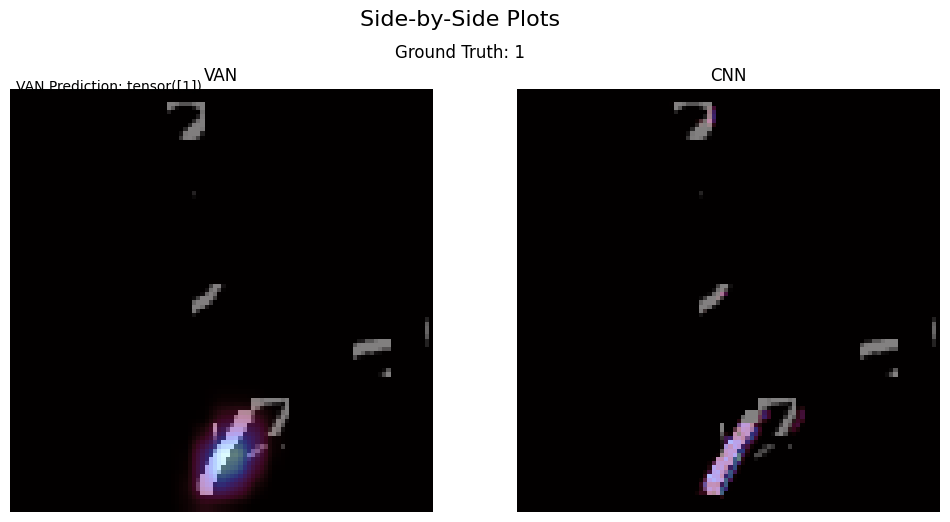

In [78]:
# Create GradCAMs.
img_id = 3 # Select image_id for GradCAM
augmented_img, ground_truth = augmented_dataset_train[img_id]
augmented_img = augmented_img.squeeze(0)
img_tensor = augmented_img
image = img_tensor.unsqueeze(0).to('cpu')

'''
output = self.model(data)
_, predicted = torch.max(output.data, 1)
'''

output_van = van(image.unsqueeze(0))
_, prediction_van = torch.max(output_van.data, 1)
output_cnn = cnn(image.unsqueeze(0))

cam_van = get_gradcam(van, image, target_layer_van)
overlay_van = overlay_cam_on_image(image, cam_van)

cam_cnn = get_gradcam(cnn, image, target_layer_cnn)
overlay_cnn = overlay_cam_on_image(image, cam_cnn)


# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(overlay_van)
axes[0].set_title('VAN')
axes[0].annotate(f'VAN Prediction: {prediction_van}', xy=(1, -0.1))
axes[0].axis('off')
axes[1].imshow(overlay_cnn)
axes[1].set_title('CNN')
axes[1].axis('off')

fig.suptitle('Side-by-Side Plots', fontsize=16)
fig.text(0.5, 0.90, f'Ground Truth: {ground_truth}', ha='center', fontsize=12)
plt.show()

In [76]:
F.softmax(output_van)

/tmp/ipykernel_34/268539198.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(output_van)


tensor([[6.5714e-09, 9.9999e-01, 1.9511e-08, 1.1298e-09, 1.5135e-07, 4.5946e-09,
         2.7642e-06, 2.6587e-06, 4.9570e-07, 2.3572e-09]],
       grad_fn=<SoftmaxBackward0>)

In [106]:
F.softmax(output_van, dim=1)

tensor([[6.3369e-08, 9.9998e-01, 7.5404e-08, 6.5448e-09, 8.7516e-07, 2.9241e-08,
         9.9585e-06, 5.1826e-06, 2.9752e-06, 2.1393e-08]],
       grad_fn=<SoftmaxBackward0>)

In [90]:
m = VAN_MNIST(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])

In [101]:
m(image.unsqueeze(0)).sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [94]:
m2 = CNN_MNIST()
m2(image.unsqueeze(0))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x147456 and 9216x128)

In [93]:
output_cnn

tensor([[3.9504e-08, 1.0000e+00, 4.3885e-17, 2.6136e-25, 4.3957e-07, 1.6146e-15,
         3.5147e-12, 1.6628e-07, 1.1997e-19, 7.4361e-10]],
       grad_fn=<SoftmaxBackward0>)

**Compare the accuracy of the models**

In [143]:
# Function to load checkpoints
def load_ckpt(path: str):
    '''
    Loads checkpoint from given path.
    '''    
    return torch.load(path)

# Load checkpoints
#van_ckt = load_ckpt()
#cnn_ckp = load_ckpt()
van_MNIST_ckpt = load_ckpt('/kaggle/working/VAN_MNIST(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4]).pth')
#cnn_MNIST_ckpt = load_ckpt()

In [161]:
van_MNIST_ckpt['running_loss_train']
van_MNIST_ckpt['running_loss_test']
van_MNIST_ckpt['test_accuracy']
van_MNIST_ckpt['train_time']
van_MNIST_ckpt.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'loss', 'running_loss_train', 'running_loss_val', 'test_accuracy', 'train_time', 'inference_time'])

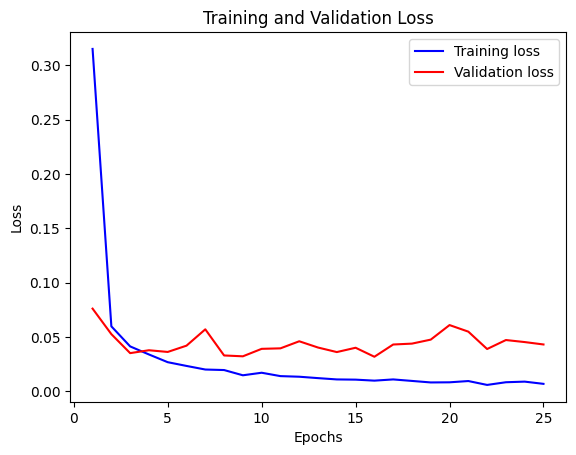

NameError: name 'van_ckpt' is not defined

In [168]:
# Plot Train and Validation Loss for models
# Funciton to plot losses
def plot_loss(train_loss, val_loss):
    '''
    Function to plot the train and validation losses during training.
    '''
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# VAN on MNIST
plot_loss(van_MNIST_ckpt['running_loss_train'], van_MNIST_ckpt['running_loss_val'])
# VAN on cluttered MNIST
plot_loss(van_ckpt['running_loss_train'], van_ckpt['running_loss_val'])
# CNN on MNIST
plot_loss(cnn_MNIST_ckpt['running_loss_train'], cnn_MNIST_ckpt['running_loss_val'])
# CNN on cluterred MNIST
plot_loss(cnn_ckpt['running_loss_train'], cnn_ckpt['running_loss_val'])

In [169]:
# Compare the Test Accuracy
import pandas as pd #pandas==2.1.4

models = ['VAN_MNIST', 'CNN_MNIST', 'VAN', 'CNN']
values = [van_MNIST_ckpt['test_accuracy'], cnn_MNIST_ckpt['test_accuracy'],
          van_ckpt['test_accuracy'], cnn_ckpt['test_accuracy']]
accuracy_df = pd.DataFrame({'Model': models,
                            'Accuracy': values})

NameError: name 'cnn_MNIST_ckpt' is not defined

In [173]:
# Compare the Test Accuracy
import pandas as pd #pandas==2.1.4
# Create accuracy table
models = ['VAN_MNIST']
values = [van_MNIST_ckpt['test_accuracy']]
accuracy_df = pd.DataFrame({'Model': models,
                            'Accuracy': values})
# Plot the values
print(accuracy_df.to_string(index=False))

    Model Accuracy
VAN_MNIST     None


# **Computational Cost Comparison**

In [175]:
# Compare number of parameters
def count_params(model):
    '''
    Funciton that returns the number of trainable parameters and the total number of parameters.
    '''
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    return trainable_params, total_paramas
# VAN
van_trainable_params, van_total_params = count_params()
print('Trainable Parameters VAN: '"{:,}".format(van_trainable_params), 'Total Parameters VAN: '"{:,}".format(van_total_params))
# CNN
cnn_trainable_params, cnn_total_params = count_params()
print('Trainable Parameters CNN: '"{:,}".format(cnn_trainable_params), 'Total Parameters CNN: '"{:,}".format(cnn_total_params))


In [ ]:
# Compare number of modueles
def count_modules(model):
    '''
    Function that returns the number of modules in a network.
    '''
    num_modules = sum(1 for _ in model.modules())
    return num_modules

van_num_modules = count_modules(baseline)
cnn_num_modules = count_modules(van)

print("Number of modules in VAN:", van_num_modules)
print("Number of modules in CNN:", cnn_num_modules)

In [ ]:
# Use deepspeed profiler to estimate FLOPS, MACS and Latency
!pip install deepspeed
from deepspeed.profiling.flops_profiler import FlopsProfiler

In [ ]:
m1 = VAN(num_classes=14, stages=2, channels=[64, 128], image_channels=3, l=[1,1], expansion_ratio=[2,4])
profile_model(input_model=m1, data_loader=pc_train_loader)

In [ ]:
def profile_model(model, data_loader=train_loader):
    '''
    Function that uses the deepspeed profiler.
    Uses a short warum-up stage and profiles at batch_idx = 50.
    '''
    # Profile a model to get the FLOPS and Latency
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    prof = FlopsProfiler(model)
    # Profile at step 50 to warmup
    profile_step = 50
    for batch_idx, (data, target) in enumerate(data_loader):
      if batch_idx == profile_step:
        prof.start_profile()

      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)

      if batch_idx == profile_step:
        prof.stop_profile()
        flops = prof.get_total_flops()
        macs = prof.get_total_macs()
        params = prof.get_total_params()
        prof.print_model_profile(profile_step=profile_step)
        prof.end_profile()

      loss.backward()
      optimizer.step()

      if batch_idx == profile_step:
        break

In [ ]:
# FLOPs for VAN
for data, target in augmented_loader:
  input_data, input_target = data.to(device), target.to(device)
  break

flops_van, params = profile(van, inputs=(input_data,))
print(f'Estimated Params for VAN:, {("{:,}".format(params))}')
print(f'Estimated FLOPs for VAN:, {("{:,}".format(flops_van))}')

In [ ]:
# Detect bottlenecks for Baseline CNN

# Define your model and input data
baseline = BaselineCNN().to(device) # Your PyTorch model
input_data = input_data  # Your input data

# Perform forward pass while profiling
with profile(profile_memory=True, record_shapes=True, use_cuda=True) as prof:
    with record_function("model_inference"):
        output = baseline(input_data)

# Print profiling results
print(prof.key_averages().table(sort_by="self_cuda_time_total"))

In [ ]:
# Detect bottlenecks for VAN

# Define your model and input data
van = VAN().to(device) # Your PyTorch model
input_data = input_data  # Your input data

# Perform forward pass while profiling
with profile(profile_memory=True, record_shapes=True, use_cuda=True) as prof:
    with record_function("model_inference"):
        output = van(input_data)

# Print profiling results
print(prof.key_averages().table(sort_by="self_cuda_time_total"))